In [9]:
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt

# Загрузка данных

В рамках данного семинара предлагается поработать с изображениями с конкурса по анализу данных Proppant Check Challenge. Описание задачи и данных можно посмотреть на сайте соревнования: https://boosters.pro/championship/RPCC

In [ ]:
!wget https://boosters.pro/api/ch/files/pub/RPCC_train.zip

--2022-04-27 05:41:53--  https://boosters.pro/api/ch/files/pub/RPCC_train.zip
Resolving boosters.pro (boosters.pro)... 91.206.14.169
Connecting to boosters.pro (boosters.pro)|91.206.14.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975138118 (930M) [application/zip]
Saving to: ‘RPCC_train.zip’

RPCC_train.zip      100%[===================>] 929.96M  23.0MB/s    in 42s     

2022-04-27 05:42:36 (22.0 MB/s) - ‘RPCC_train.zip’ saved [975138118/975138118]



In [ ]:
!unzip -q RPCC_train.zip

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1NYwDvq-mSXKwcKZyK0VoGbD6J3dnMoU1'
downloaded = drive.CreateFile({'id': file_id})

# Save file to disk
downloaded.GetContentFile('instances.json')

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1O2HUPJNw5EdYLN8FucT13Zp3x96IEtnZ'
downloaded = drive.CreateFile({'id': file_id})

# Save file to disk
downloaded.GetContentFile('template.png')

In [ ]:
TRAIN_FOLDER = 'train'

# Работа с изображением

Основным заданием будет создание алгоритма предобработки изображений для решения следующей задачи:

**Входные данные:** фотография листа бумаги с нанесенным шаблоном и рассыпанным пропаннатом

**Выходные данные:** кроп входного изображения, содержащего только область с проппанатом.

In [ ]:
IMAGE_ID = 1

In [ ]:
img = cv2.imread(os.path.join(TRAIN_FOLDER, str(IMAGE_ID) + '.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Изображения в датасете сняты на камеру мобильного телефона под некоторым углом и с некоторого расстояния:

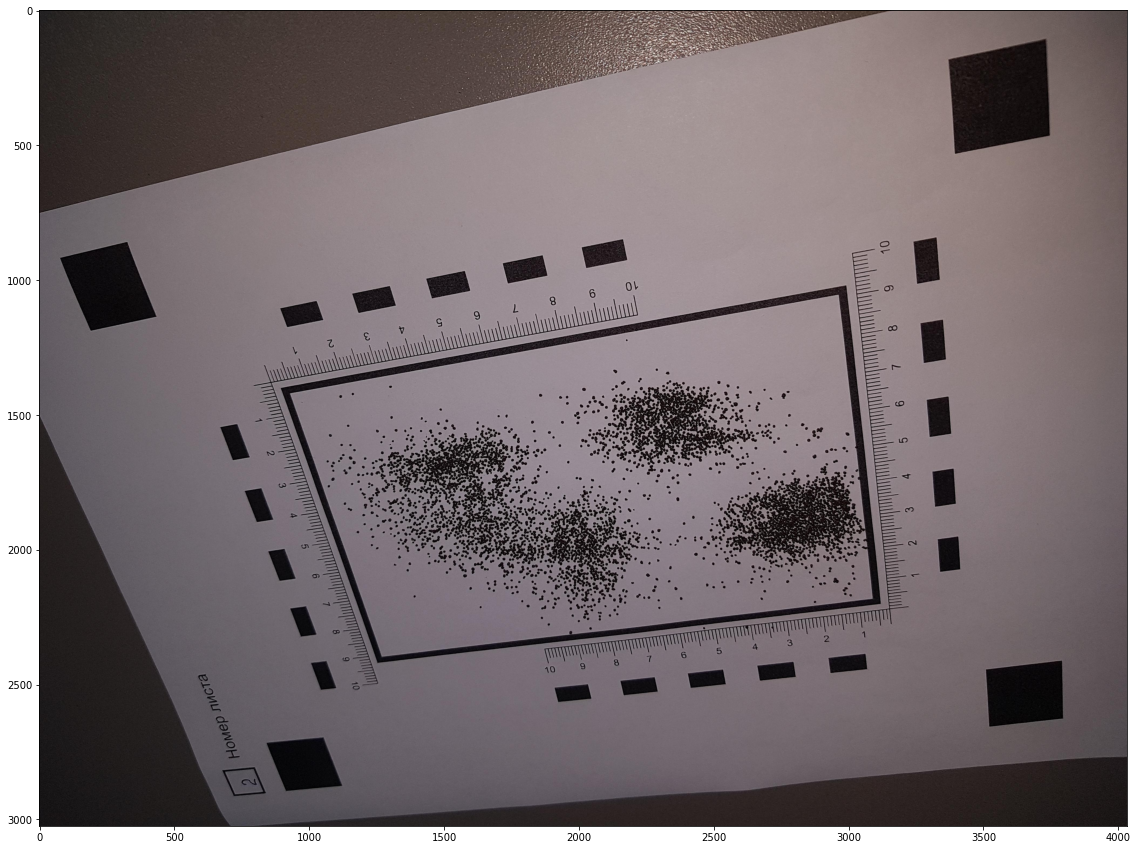

In [ ]:
plt.figure(figsize=[20, 15])
plt.imshow(img)

На всех фотографиях снят лист бумаги с распечатанным шаблоном и рассыпанным на нем проппанатом. Шаблон извествен:

In [10]:
template = cv2.imread('template.png')

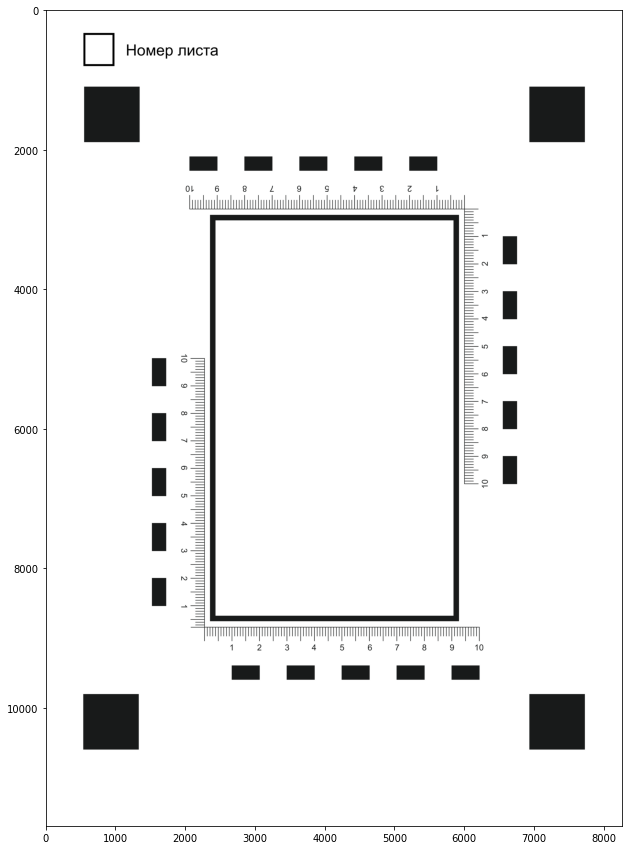

In [11]:
plt.figure(figsize=[20, 15])
plt.imshow(template)

Далее рассмотрим примеры использования алгоритмов, которые могут быть полезны при решении данной задачи извлечения области с проппанатом.

### Бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Реализация обычной пороговой бинаризации в OpenCV представлена функцией cv2.threshold с флагом cv2.THRESH_BINARY. Другие флаги, такие как cv2.THRESH_TRUNC
cv2.THRESH_TOZERO определяют, будут ли изменены значения ниже или выше порога

In [12]:
ret, th_const = cv2.threshold(
    gray,                   # входное изображение
    128,                    # порог бинаризации
    255,                    # максимальное значения пикселя изображения
    cv2.THRESH_BINARY       # способ бинаризации (cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV)
)

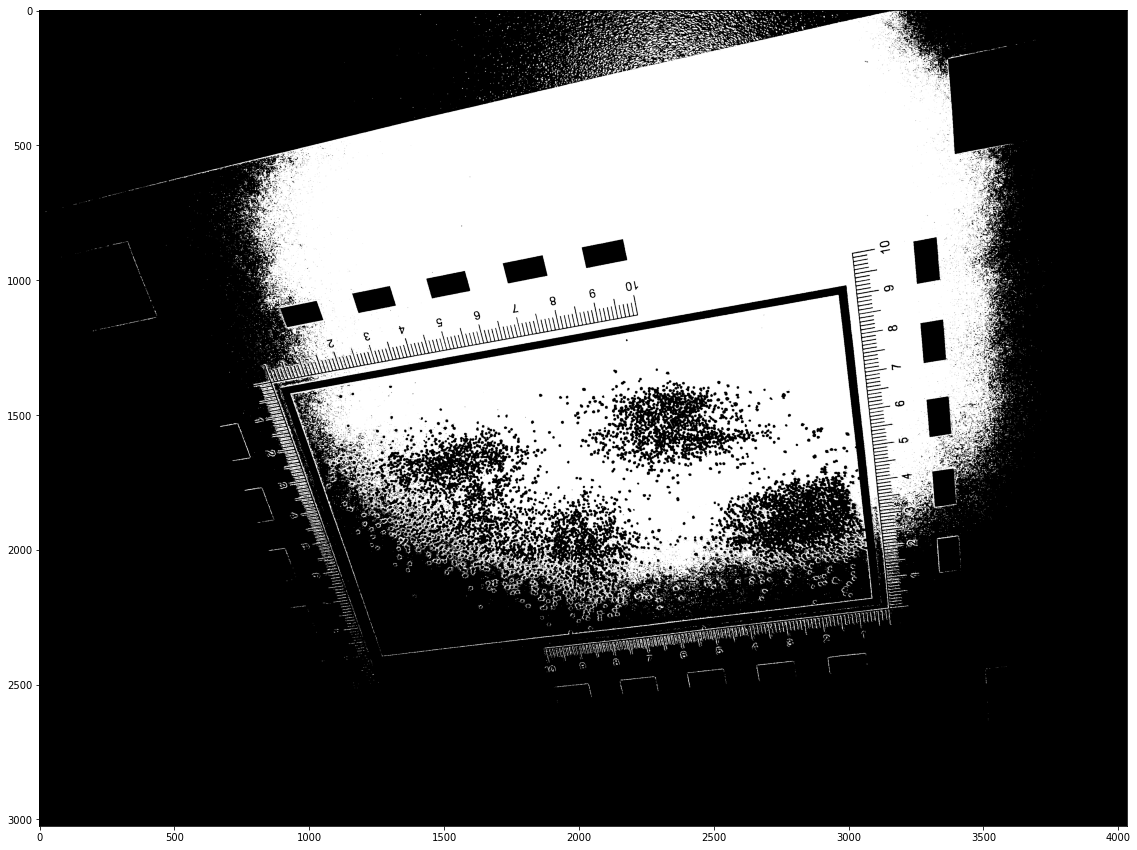

In [13]:
plt.figure(figsize=[20, 15])
plt.imshow(th_const, cmap='Greys_r')

# Вопрос 1
В чем заключается недостаток обычной бинаризации по константному порогу?

**Ответ:** На изображении может быть разная освещенность, поэтому плохо отрезать по порогу.

Недостаток подхода очевиден. Впрочем, можно попробовать подобрать оптимальный порог вручную, основываясь на визуальной оценке качества бинаризации, или осуществить поиск оптимального порога по методу Отсу. Делается это передачей дополнительного флага cv2.THRESH_OTSU:

In [14]:
ret, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [15]:
print('Оптимальный порог бинаризации по Отсу: ', ret)

Оптимальный порог бинаризации по Отсу:  79.0


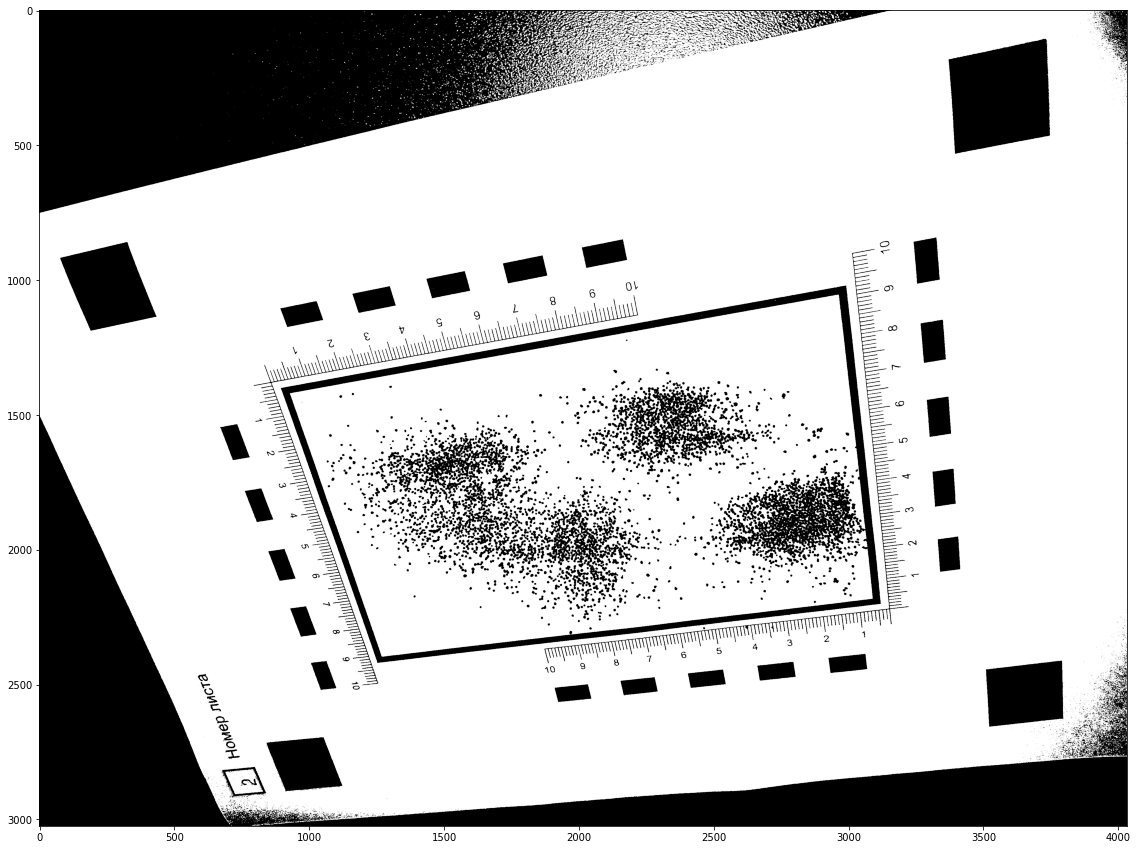

In [16]:
plt.figure(figsize=[20, 15])
plt.imshow(th_otsu, cmap='Greys_r')

Уже значительно лучше. Но попробуем адаптивную бинаризацию

### Адаптивная бинаризация

Туториал: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

Адаптивная бинаризация в OpenCV представлена методом cv2.adaptiveThreshold:

In [17]:
th_adaptive = cv2.adaptiveThreshold(
    gray,                        # входное изображение
    255,                         # максимальное значения пикселя изображения
    cv2.ADAPTIVE_THRESH_MEAN_C,  # способ вычисления порога (cv2.ADAPTIVE_THRESH_MEAN_C - среднее, cv.ADAPTIVE_THRESH_GAUSSIAN_C - взвешенное среднее, с весами по гауссиане)
    cv2.THRESH_BINARY,           # способ бинаризации (те же, что и для неадаптивной)
    51,                          # размер окрестности пикселя, рассматриваемой при вычислении порога (должна быть нечетной)
    0                            # это значение вычитается из вычисленного порога, полученная величина - фактический порог бинаризации
)

In [18]:
plt.figure(figsize=[20, 15])
plt.imshow(th_adaptive, cmap='Greys_r')

Output hidden; open in https://colab.research.google.com to view.

Получилось не очень, но, возможно, поможет подбор параметров!

# Вопрос 2

Исходя из результатов работы адаптивной бинаризации, попробуйте определить, какие характеристики исходного изображения могли привести к таким результатам? Другими словами, устойчивость к каким характеристикам входных данных требуется повысить с помощью варьирования параметров или применения дополнительных методов для того, чтобы улучшить результат?

**Ответ:** Если увеличить C, вычитаемое значение из порога, то получится результат лучше. Получается, с помощью этого порога хотим повысить устойчивость к разному освещению, шуму.

### Морфологические преобразования

Туториал: https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html

Попробуем 'очистить' результаты адаптивной бинаризации, сохранив только ярко выраженные границы. Достигнуть этого можно с помощью морфологического преобразования 'opening' (открытия, раскрытия):

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9, 9))
th_adaptive_cl = cv2.morphologyEx(th_adaptive, cv2.MORPH_CLOSE, kernel, None, None, 2)
print('Ядро морфилогической операции:\n\n', kernel)

Ядро морфилогической операции:

 [[0 0 0 0 1 0 0 0 0]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 0]
 [0 0 0 0 1 0 0 0 0]]


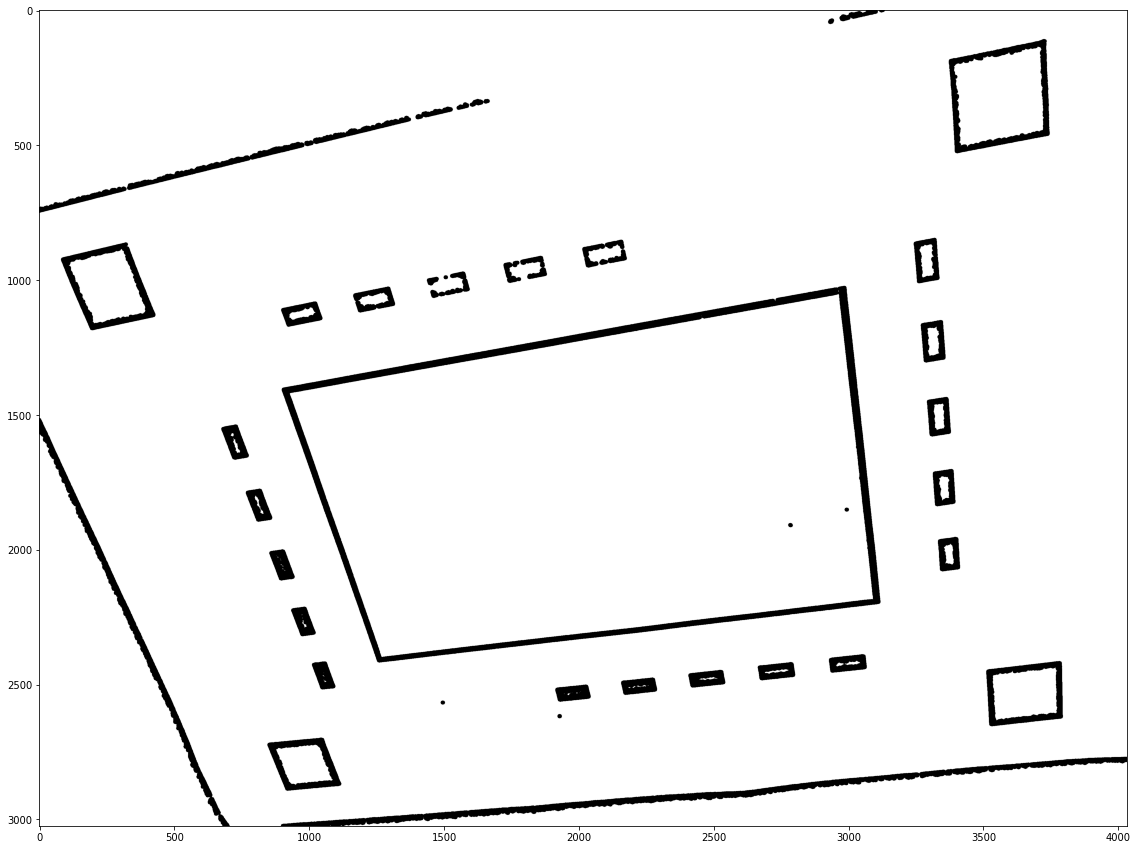

In [21]:
plt.figure(figsize=[20, 15])
plt.imshow(th_adaptive_cl, cmap='Greys_r')

### Выделение границ

Туториал: https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

Для выделения границ наиболее популярным является метод Канни:

In [22]:
edges = cv2.Canny(
    th_otsu,    # входное изображение
    100,        # нижний порог гистерезиса
    200,        # верхний порог гистерезиса
    None,       # буфер для ребер, укажем None, так как воспользуемся возвращаемым значением
    3,          # размер ядра дифференциального оператора Собеля
    True        # False/True L1/L2 норма для вичисления отклика по производным
)

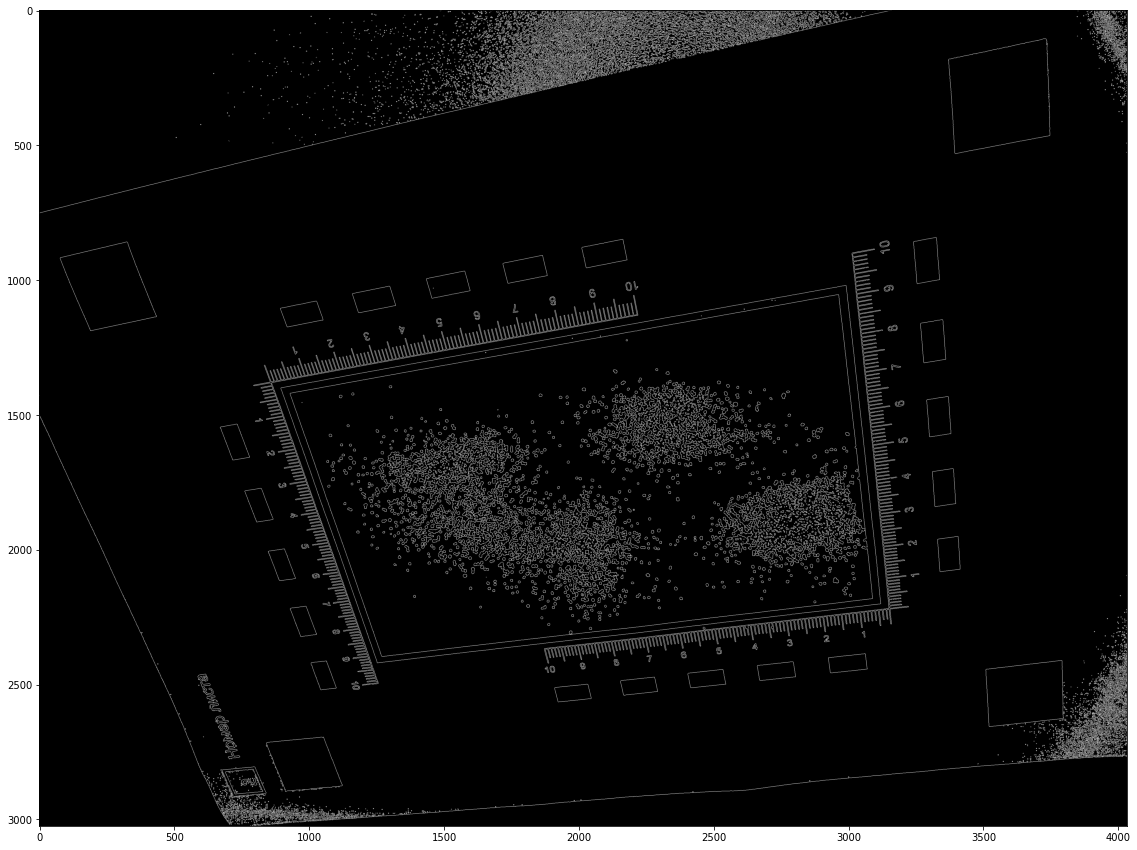

In [23]:
plt.figure(figsize=[20, 15])
plt.imshow(edges, cmap='Greys_r')

# Вопрос 3
Для чего применяется процедура гистерезиса в детекторе Канни? Как влияют на результат пороги гистерезиса?

**Ответ:** Для того, чтобы определить, какие границы реальные, а какие фейковые. Выделяем два порога: max и min. Границы со значениями интенсивности градиента меньше min сразу отбрасываются, со значениями больше max сразу принимаются. Границы со значениями в интервале от min до max остаются, если связаны с границами со значениями больше max. По факту эти пороги влияют, насколько сильные границы изображения мы выделим.

### Выделение контуров

Туториал: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Для работы с контурами могут быть полезны следующие средства:

1. cv2.findContours - поиск контуров
2. cv2.contourArea - площадь фигуры, ограниченной контуром
3. cv2.arcLength - длина контура
4. cv2.isContourConvex - проверка на выпуклость
5. cv2.approxPolyDP - аппроксимация контура более простым (состоящим из меньшего числа звеньев)
6. cv2.drawContours - отрисовка контуров

In [24]:
contours, hierarchy = cv2.findContours(
    th_otsu,                 # входное изображение, бинаризованное
    cv2.RETR_TREE,           # восстановить иерархию контуров по вложенности друг в друга
    cv2.CHAIN_APPROX_NONE    # не аппроксимировать контуры
)

In [25]:
img_countours = img.copy()
img_countours = cv2.drawContours(img_countours, contours, -1, (255,0,0), 3)

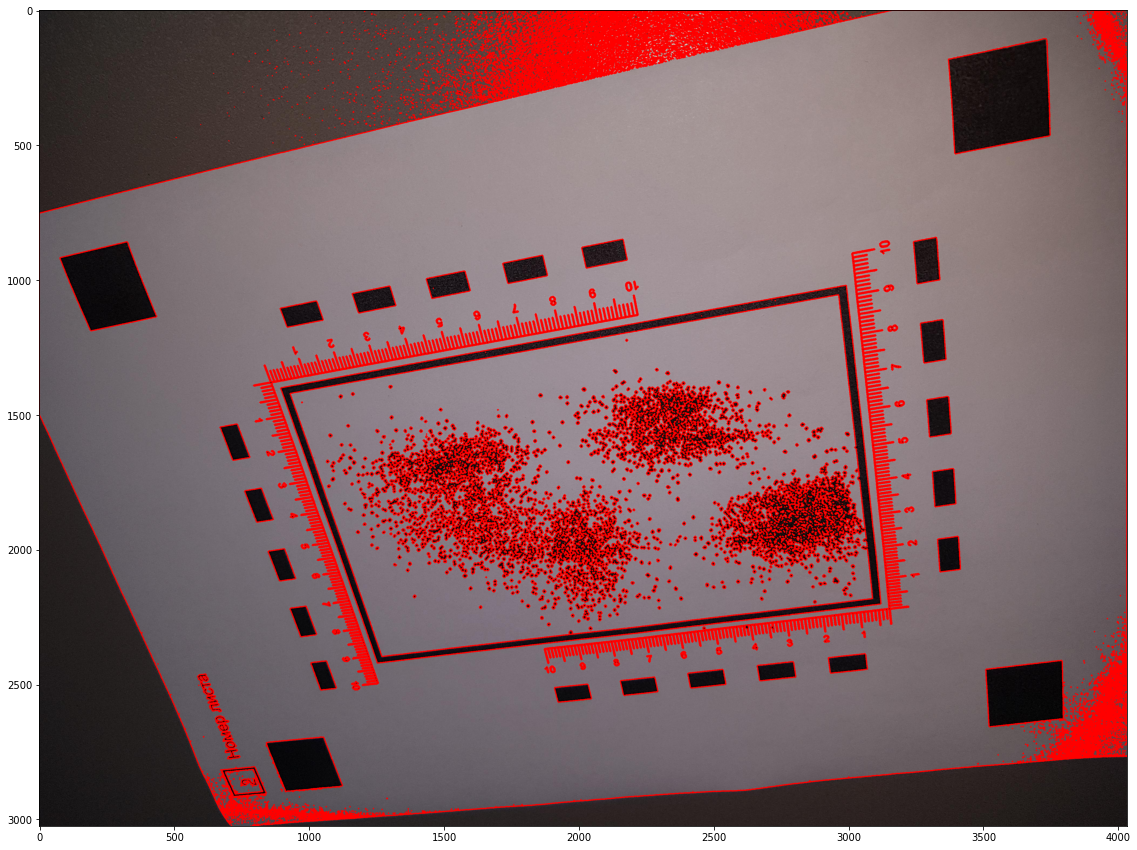

In [26]:
plt.figure(figsize=[20, 15])
plt.imshow(img_countours)

# Вопрос 4
На лекции были рассмотрен методы сопоставления с шаблоном (анализ краев, кросс-корреляция). В нашей задаче тоже есть изображение и шаблон. Оцените применимость этих методов в задаче.

**Ответ:** Если оставить только ярко выраженные границы, то метод с дескрипторной оценкой контуров должен сработать, потому что он инварентен к повороту и масштабированию. 
Chamfer Distance или Hausdorff Distance я думаю, что не сработают, потому что слишком сложный шаблон. 


# Задание 1

Используя средства OpenCV реазизуйте извлечение области с пропаннатом из изображения. Продемонстрируйте работу предложенного подхода еще на 2х изображениях. Также приведите пример минимум 2-х изображений, где проявляются его недостатки. Предложите (на словах) как их можно исправить.

Примечание: возможно, для выполнения задания дополнительно понадобится применить методы подавления шума и гистограмных преобразований, которые были рассмотрены на предыдущих семинарах. Для извлечения прямоугольной области понадобится аппарат проективных преобразований, представленный функциями cv2.getPerspectiveTransform - по 4 парам соответствующих точек выдает матрицу гомографии, cv2.warpPerspective - применяет преобразование гомографии.

## Решение

Сначала выделим границы на изображении. К ним будут отнесены границы поисковых узоров в том числе. Но не только они. Кроме того присутствует шум типа "перец". Его можно удалить, но, как дальше было выяснено, это не влияет на качество выделения линий.

Примечание: это не результат работы детектора Canny

In [363]:
def find_propan(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # выровняли гистограмму
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    clahe_gray = clahe.apply(gray)
    # биноризовали
    adaptive = cv2.adaptiveThreshold(clahe_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 6)
    # очистили изображение
    final_gray = cv2.medianBlur(adaptive, 15)
    # нашли контуры
    contours, hierarchy = cv2.findContours(final_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # берем третий максимальный контур, 
    # тк первый максимум вокруг всего листа, 
    # а второй - внешний контур нужного прямоугольника, а нам нужен внутренний
    countours_area = np.array(list(map(lambda x: cv2.contourArea(x), contours)))
    sorted_countours_idx = np.argsort(countours_area)[::-1]
    rec_id = sorted_countours_idx[2]

    x, y, w, h = cv2.boundingRect(contours[rec_id])

    f, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2))
    ax[0].axis('off')

    source = np.array([[x, y], [x, y + h], [x + w, y + h], [x + w, y]], dtype='float32')
    dist = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype='float32')
    M = cv2.getPerspectiveTransform(source, dist)

    out = cv2.warpPerspective(img, M, (w, h))

    ax[1].imshow(out)
    ax[1].axis('off')
    plt.show()

## Хорошие примеры

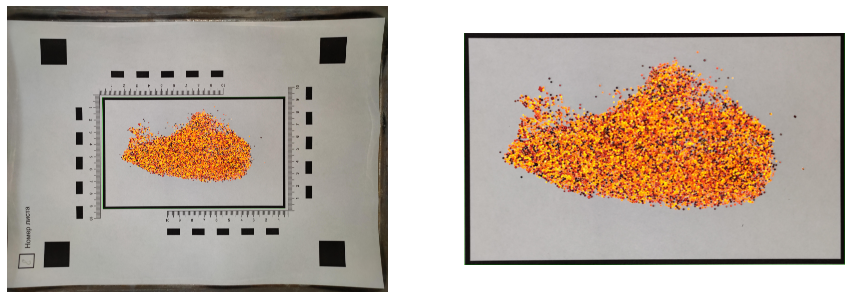

In [365]:
find_propan(cv2.cvtColor(cv2.imread(os.path.join(TRAIN_FOLDER, str(102) + '.jpg')), cv2.COLOR_BGR2RGB))

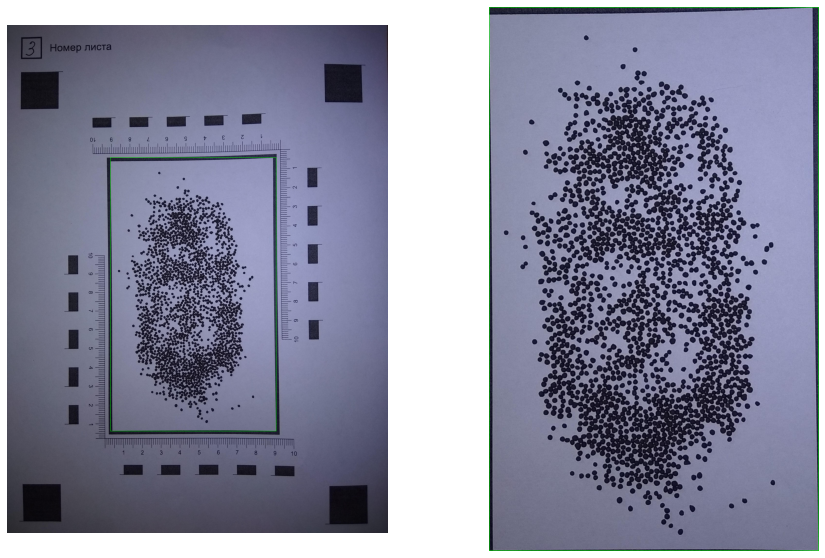

In [366]:
find_propan(cv2.cvtColor(cv2.imread(os.path.join(TRAIN_FOLDER, str(6) + '.jpg')), cv2.COLOR_BGR2RGB))

## Плохие примеры

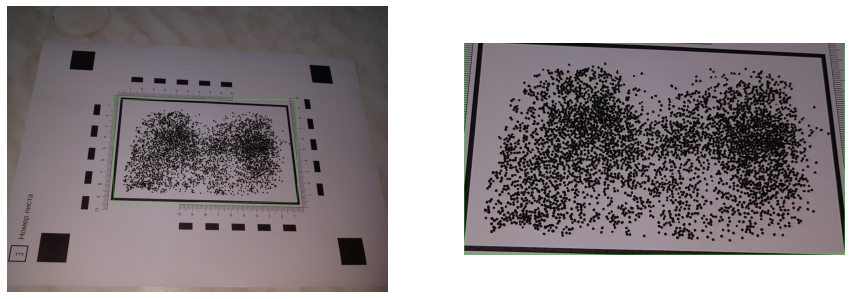

In [364]:
find_propan(cv2.cvtColor(cv2.imread(os.path.join(TRAIN_FOLDER, str(15) + '.jpg')), cv2.COLOR_BGR2RGB))

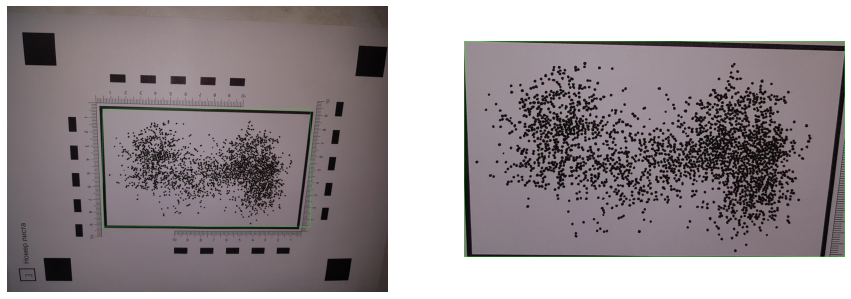

In [386]:
find_propan(cv2.cvtColor(cv2.imread(os.path.join(TRAIN_FOLDER, str(115) + '.jpg')), cv2.COLOR_BGR2RGB))

 ## Выводы

 Нет инвариантности к наклонам, можно попробовать сильнее фильтровать шум или сразу детектить именно линии с помощью алгоритма Хафа.